In [1]:
!pip install audformat
!pip install librosa
!pip install audiofile
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.0/129.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.4/167.4 kB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for iso-639: filename=iso_639-0.4.5-py3-none-any.whl size=168841 sha256=ce0ef2879104e34d9dcf3f8a3fee67334487e4cd71d7337b7ddd55ba3a8fc622
  Stored in directory: /root/.cache/pip/wheels/d8/78/cc/5478ca3b1c3f602eae6f8cdbd78f909c0a0bfa0bbcb5c7771f
Successfully built iso-639
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 1.3 MB/s eta 0:00:00


**Libraries loading**

In [2]:
import audformat
import audiofile
import librosa
import librosa.display

# Import the audio playback widget
import IPython.display as ipd
from IPython.display import Image

import matplotlib.pyplot as plt
from keras_preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import keras
from keras import layers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import SMOTE
import numpy as np

import math

**Downloading dataset**

In [3]:
!wget https://zenodo.org/record/7447302/files/emodb.zip

!unzip emodb.zip

--2023-11-11 21:05:02--  https://zenodo.org/record/7447302/files/emodb.zip
Resolving zenodo.org (zenodo.org)... 188.185.22.33, 188.185.33.206, 188.185.10.78, ...
Connecting to zenodo.org (zenodo.org)|188.185.22.33|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7447302/files/emodb.zip [following]
--2023-11-11 21:05:03--  https://zenodo.org/records/7447302/files/emodb.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 39981818 (38M) [application/octet-stream]
Saving to: ‘emodb.zip’

emodb.zip           100%[===================>]  38.13M  15.3MB/s    in 2.5s    

2023-11-11 21:05:06 (15.3 MB/s) - ‘emodb.zip’ saved [39981818/39981818]

Archive:  emodb.zip
   creating: emodb/
  inflating: emodb/db.emotion.categories.train.gold_standard.pkl  
   creating: emodb/wav/
  inflating: emodb/wav/14b01Fc.wav   
  inflating: emodb/wav/14a02Ea.wav   
  inflating: emodb/wav/15a02Ta.wav   
  infla

**Inializing constants**

In [4]:
# constants
sr = 16000
duration = 5
frame_length = 512
N_FRAMES = math.ceil(sr*duration/frame_length)
N_FEATURES = 174
N_EMOTIONS = 7
labels_encoded = {'anger':0, 'boredom':1, 'disgust':2, 'fear':3, 'happiness':4, 'sadness':5, 'neutral':5}
path = "emodb/"

**Loading dataset**

using the gold standard train and test data

In [5]:

db = audformat.Database.load('emodb')

df_test = db['emotion.categories.test.gold_standard'].get()

df_train = db['emotion.categories.train.gold_standard'].get()

print(f'samples in train: {df_train.shape[0]}, and test: {df_test.shape[0]}')

samples in train: 304, and test: 231


In [6]:
labels_encoded = {'anger':0, 'boredom':1, 'disgust':2, 'fear':3, 'happiness':4, 'sadness':5, 'neutral':6}
df_train['label']=df_train['emotion'].apply(lambda x:labels_encoded[x])
df_test['label']=df_test['emotion'].apply(lambda x:labels_encoded[x])

**Data Analysis**

In [7]:
df_test

,emotion,emotion.confidence,label
file,,,
wav/12a01Fb.wav,happiness,0.95,4
wav/12a01Lb.wav,boredom,0.90,1
wav/12a01Nb.wav,neutral,0.95,6
wav/12a01Wc.wav,anger,0.95,0
wav/12a02Ac.wav,fear,0.90,3
...,...,...,...
wav/16b10Lb.wav,boredom,1.00,1
wav/16b10Tb.wav,sadness,0.90,5
wav/16b10Td.wav,sadness,0.95,5


In [8]:
df_test.emotion.unique()

['happiness', 'boredom', 'neutral', 'anger', 'fear', 'disgust', 'sadness']
Categories (7, object): ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'sadness', 'neutral']

In [9]:
data, sampling_rate = librosa.load('emodb/'+df_test.index[0])

In [10]:
len(data)

41093

In [11]:
data[0]

3.048674e-05

In [12]:
ipd.Audio('emodb/'+df_test.index[0])

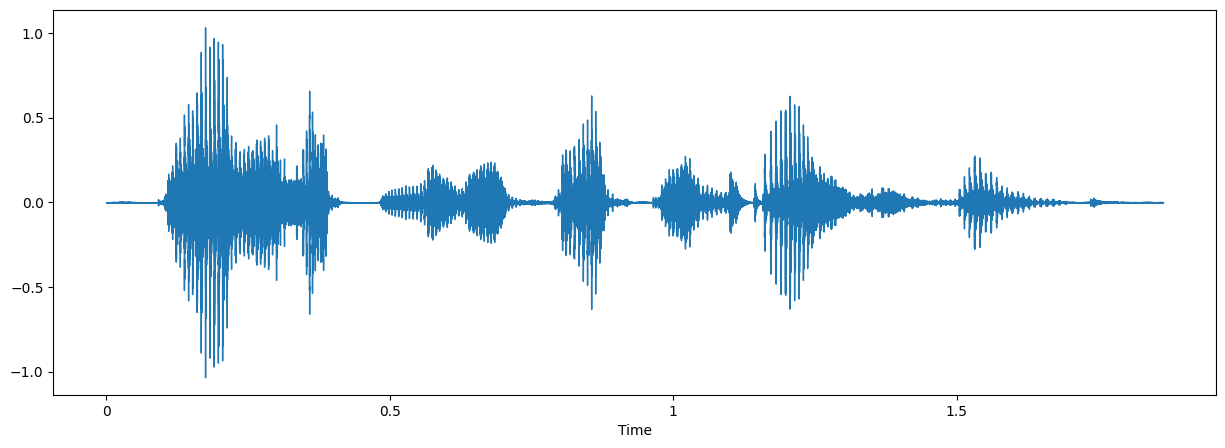

In [13]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

(array([55., 36.,  0., 26.,  0., 33., 27.,  0., 27., 27.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

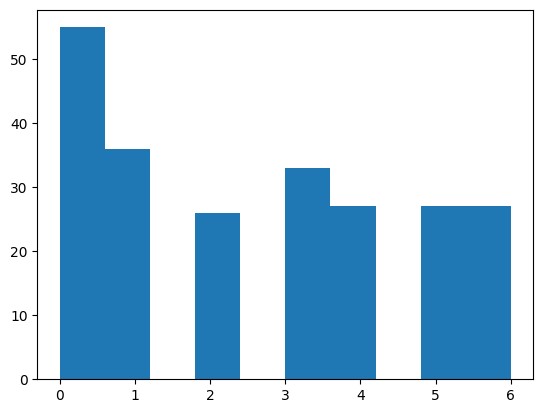

In [14]:
plt.hist(df_test['label'])

In [15]:
data_mspect = librosa.feature.melspectrogram(y = data , sr = sampling_rate)

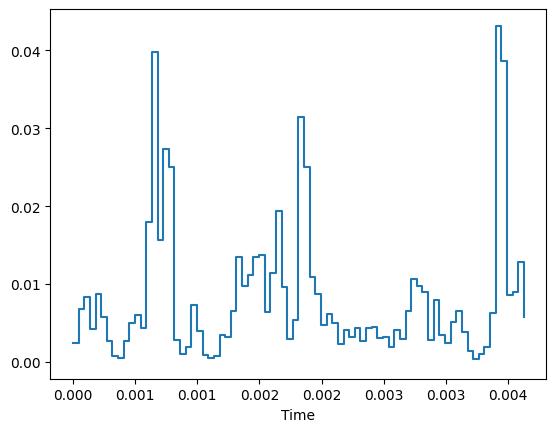

In [16]:
librosa.display.waveshow(data_mspect, sr=sampling_rate)

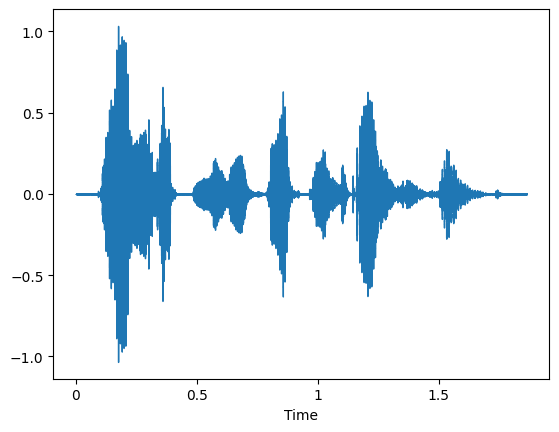

In [17]:
librosa.display.waveshow(data, sr=sampling_rate)

**Feature Extraction**

Extracting spectrogram features

In [18]:
def feature_extraction(df):
    features = [] #(N_SAMPLES, N_FRAMES, N_FEATURES)
    emotions = df.label
    waves=[]
    for fnm in df.index:
      y, sampling_rate = librosa.load(path +  fnm, sr=sr, mono=True, duration=duration)
      waves.append(y)
    # pad to fixed length (zero, 'pre')
    waves_padded = pad_sequences(waves, maxlen=sr * duration, dtype="float32")
    for y in waves_padded:
      frames = []
      spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr, hop_length=frame_length)[0]
      spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr, hop_length=frame_length)[0]
      spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr, hop_length=frame_length)[0]
      spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, hop_length=frame_length)[0]
      zero_crossing_rate = librosa.feature.zero_crossing_rate(y, hop_length=frame_length)[0]
      S, phase = librosa.magphase(librosa.stft(y=y, hop_length=frame_length))
      rms = librosa.feature.rms(y=y, hop_length=frame_length, S=S)[0]
      mfcc = librosa.feature.mfcc(y=y, sr=sr, hop_length=frame_length)
      mfcc_der = librosa.feature.delta(mfcc)
      feat_mspect = librosa.feature.melspectrogram(y=y , sr = sampling_rate)
      # print(feat_mspect.shape,mfcc.shape,N_FRAMES)
      for i in range(N_FRAMES):
        f=[]
        f.append(spectral_centroid[i])
        f.append(spectral_contrast[i])
        f.append(spectral_bandwidth[i])
        f.append(spectral_rolloff[i])
        f.append(zero_crossing_rate[i])
        f.append(rms[i])
        for m_coeff in mfcc[:,i]:
            f.append(m_coeff)
        for m_coeff_der in mfcc_der[:, i]:
            f.append(m_coeff_der)
        for m_spect in feat_mspect[:, i]:
            f.append(m_spect)
        frames.append(f)
        # print(len(f))

      features.append(frames)

    features = np.array(features)
    # flatten
    N_SAMPLES = len(features)
    features.shape = (N_SAMPLES, N_FRAMES * N_FEATURES)
    # standardize data
    scaler = StandardScaler()
    features = scaler.fit_transform(features)
    emotions = np.array(emotions)
    return features,emotions

In [19]:
X_train,y_train=feature_extraction(df_train)
X_test,y_test=feature_extraction(df_test)

**Class Balancing**

In [20]:
# # balance train classes
sm = SMOTE()
X_train, y_train = sm.fit_resample(X_train, y_train)
# restore 3D shape
X_train.shape = (len(X_train), N_FRAMES, N_FEATURES)
X_test.shape = (len(X_test), N_FRAMES, N_FEATURES)

**Encoding the output classes into One hot encoding format**

In [21]:
encoder = OneHotEncoder(sparse=False)
y_train= y_train.reshape(-1, 1)
print(y_train.shape)
y_train = encoder.fit_transform(y_train)
print(y_train.shape)
y_test= y_test.reshape(-1, 1)
print(y_test.shape)
y_test = encoder.fit_transform(y_test)
print(y_test.shape)

(504, 1)
(504, 7)
(231, 1)
(231, 7)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
print(X_train.shape)
print(y_train.shape)

(504, 157, 174)
(504, 7)


Applying Convolutional Neural Network model

In [23]:

model = models.Sequential([
    layers.Reshape((X_train.shape[1],X_train.shape[2],1),input_shape=X_train.shape[1:]),
    layers.Conv2D(32,(4,4), activation='relu',input_shape=X_train.shape[1:]),
    layers.MaxPooling2D(pool_size=(3, 3)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(N_EMOTIONS, activation='softmax')  # Output layer with number of emotions
])


In [24]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(str(model.summary()))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 157, 174, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 154, 171, 32)      544       
                                                                 
 max_pooling2d (MaxPooling2  (None, 51, 57, 32)        0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 93024)             0         
                                                                 
 dense (Dense)               (None, 128)               11907200  
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                        

In [ ]:
best_weights_file = "cnn_weights.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
mc = ModelCheckpoint(best_weights_file, monitor='val_loss', mode='min', verbose=2,
                         save_best_only=True)
model.fit(X_train, y_train, epochs=30, batch_size=8, validation_split=0.2,callbacks=[es, mc])

Epoch 1/30
51/51 [==============================] - ETA: 0s - loss: 3.9248 - accuracy: 0.5112
Epoch 1: val_loss improved from inf to 0.41589, saving model to cnn_weights.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 21s 395ms/step - loss: 3.9248 - accuracy: 0.5112 - val_loss: 0.4159 - val_accuracy: 0.8911
Epoch 2/30
51/51 [==============================] - ETA: 0s - loss: 0.3452 - accuracy: 0.8958
Epoch 2: val_loss improved from 0.41589 to 0.27028, saving model to cnn_weights.h5
51/51 [==============================] - 22s 430ms/step - loss: 0.3452 - accuracy: 0.8958 - val_loss: 0.2703 - val_accuracy: 0.9307
Epoch 3/30
51/51 [==============================] - ETA: 0s - loss: 0.1020 - accuracy: 0.9752
Epoch 3: val_loss did not improve from 0.27028
51/51 [==============================] - 18s 357ms/step - loss: 0.1020 - accuracy: 0.9752 - val_loss: 0.6484 - val_accuracy: 0.9406
Epoch 4/30
51/51 [==============================] - ETA: 0s - loss: 0.0877 - accuracy: 0.9876
Epoch 4: val_loss improved from 0.27028 to 0.04049, saving model to cnn_weights.h5
51/51 [==============================] - 18s 363ms/step - loss: 0.0877 - accuracy: 0.9876 - val_loss: 0.0405 

In [31]:
# test acc and loss
model.load_weights(best_weights_file) # load the best saved model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
test_metrics = model.evaluate(X_test, y_test, batch_size=32)
print("\n%s: %.2f%%" % ("test " + model.metrics_names[1], test_metrics[1] * 100))
print("%s: %.2f" % ("test " + model.metrics_names[0], test_metrics[0]))
print("test accuracy: " + str(format(test_metrics[1], '.3f')) + "\n")
print("test loss: " + str(format(test_metrics[0], '.3f')) + "\n")
# test acc and loss per class

8/8 [==============================] - 14s 706ms/step - loss: 1.4638 - accuracy: 0.6277

test accuracy: 62.77%
test loss: 1.46
test accuracy: 0.628

test loss: 1.464



Also, using BiLSTM Attention model

In [ ]:
def create_model(units=256):
    input = keras.Input(shape=(N_FRAMES, N_FEATURES))
    states, forward_h, _, backward_h, _ = layers.Bidirectional(
        layers.LSTM(units, return_sequences=True, return_state=True)
    )(input)
    last_state = layers.Concatenate()([forward_h, backward_h])
    hidden = layers.Dense(units, activation="tanh", use_bias=False,
                          kernel_initializer=keras.initializers.RandomNormal(mean=0., stddev=1.)
                          )(states)
    out = layers.Dense(1, activation='linear', use_bias=False,
                          kernel_initializer=keras.initializers.RandomNormal(mean=0., stddev=1.)
                          )(hidden)
    flat = layers.Flatten()(out)
    energy = layers.Lambda(lambda x:x/np.sqrt(units))(flat)
    normalize = layers.Softmax()
    normalize._init_set_name("alpha")
    alpha = normalize(energy)
    context_vector = layers.Dot(axes=1)([states, alpha])
    context_vector = layers.Concatenate()([context_vector, last_state])

    pred = layers.Dense(N_EMOTIONS, activation="softmax")(context_vector)
    model = keras.Model(inputs=[input], outputs=[pred])
    model._init_set_name('Attention_BLSTM')
    print(str(model.summary()))
    return model

In [ ]:
model=create_model()

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [32]:
best_weights_file = "attention_bilstm_weights.h5"
es = EarlyStopping(monitor='val_loss', mode='min', verbose=2, patience=10)
mc = ModelCheckpoint(best_weights_file, monitor='val_loss', mode='min', verbose=2,
                         save_best_only=True)
model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=8,
        validation_split=0.2,
        callbacks=[es, mc],
        verbose=2
    )

Epoch 1/30

Epoch 1: val_loss improved from inf to 0.00456, saving model to attention_bilstm_weights.h5
51/51 - 50s - loss: 0.0125 - accuracy: 0.9950 - val_loss: 0.0046 - val_accuracy: 1.0000 - 50s/epoch - 985ms/step
Epoch 2/30

Epoch 2: val_loss did not improve from 0.00456
51/51 - 47s - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.2834 - val_accuracy: 0.9208 - 47s/epoch - 913ms/step
Epoch 3/30

Epoch 3: val_loss did not improve from 0.00456
51/51 - 45s - loss: 0.0970 - accuracy: 0.9677 - val_loss: 0.0190 - val_accuracy: 1.0000 - 45s/epoch - 879ms/step
Epoch 4/30

Epoch 4: val_loss did not improve from 0.00456
51/51 - 44s - loss: 0.0131 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000 - 44s/epoch - 865ms/step
Epoch 5/30

Epoch 5: val_loss did not improve from 0.00456
51/51 - 44s - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0130 - val_accuracy: 1.0000 - 44s/epoch - 866ms/step
Epoch 6/30

Epoch 6: val_loss did not improve from 0.00456
51/51 - 43s - loss: 0.0022 - accurac

In [33]:
# test acc and loss
model.load_weights(best_weights_file) # load the best saved model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
test_metrics = model.evaluate(X_test, y_test, batch_size=32)
print("\n%s: %.2f%%" % ("test " + model.metrics_names[1], test_metrics[1] * 100))
print("%s: %.2f" % ("test " + model.metrics_names[0], test_metrics[0]))
print("test accuracy: " + str(format(test_metrics[1], '.3f')) + "\n")
print("test loss: " + str(format(test_metrics[0], '.3f')) + "\n")
# test acc and loss per class

8/8 [==============================] - 5s 371ms/step - loss: 1.6772 - accuracy: 0.6364

test accuracy: 63.64%
test loss: 1.68
test accuracy: 0.636

test loss: 1.677

